In [1]:
from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np

power = 3

def dir(point: np.array) -> np.array:
            direction = (np.abs(point) == 1) * (np.sign(point)) 
            return np.array(direction, dtype=int)

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

# c_p_1d = f_collocation_points(int(np.ceil(power/2))).reshape(int(np.ceil(power/2))+1)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))

def exact_sol(point):
    y, x = point
    return x**2 * y

# def exact_der(point):
#     x, y = point
#     return x**2 * y

def f(point):
    y, x = point
    return 2*x*y + x**2

params = {
    'n_dims': 2,
    'dim_sizes': np.array([4, 4]),
    'area_lims': np.array([[0,1], [0,1]]),
    'power': power,
    'basis': Basis(power),
}
sol = Solution(**params)

connect_points = np.array([[-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],])
border_points = connect_points

w = (sol.steps[0]/2)

colloc_left_operators = [lambda u_loc, u_bas, x, x_loc: (u_bas([1,0]) + u_bas([0,1])) * w]
colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: f(x) * w]
colloc_ops = [colloc_left_operators, colloc_right_operators]

border_left_operators = [lambda _, u_bas, x, x_loc: u_bas([0,0]), 
                            # lambda _, u_bas, x, x_loc: u_bas([1,0]) * w
                            ]
border_right_operators = [lambda u, _, x, x_loc: exact_sol(x),
                            # lambda u, _, x, x_loc: 0 * w
                            ]
border_ops = [border_left_operators, border_right_operators]

points = (colloc_points, connect_points, border_points)

connect_left_operators = [lambda _, u_bas, x, x_loc: u_bas(0*dir(x_loc)) + np.sum(dir(x_loc)) * u_bas(dir(x_loc)) * w,
                        lambda _, u_bas, x, x_loc: u_bas(2*dir(x_loc))* w**2 + np.sum(dir(x_loc)) * u_bas(3*dir(x_loc))* w**3
                        ]
connect_right_operators = [lambda _, u_nei, x, x_loc: u_nei(0*dir(x_loc)) + np.sum(dir(x_loc))*u_nei(dir(x_loc))* w,
                            lambda _, u_nei, x, x_loc: u_nei(2*dir(x_loc))* w**2 + np.sum(dir(x_loc)) * u_nei(3*dir(x_loc))* w**3
                            ]
connect_ops = [connect_left_operators, connect_right_operators]

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
        'connect_ops':connect_ops}

sol.solve(verbose = True, **iteration_dict)

2.144436946929939
0.6419426688643931
0.8530307468343591
0.6312425248596465
0.44650042659430883
0.24116419731360672
0.09350662498824
0.026543980181960084
0.006684462479308103
0.0025321211321629455
0.0020857198236659477
0.0011664192532154088
0.0004939199834673655
0.00015912984921359619
3.772755519406302e-05
1.0035852231138342e-05
9.121882074226983e-06
Iterations to converge:  16


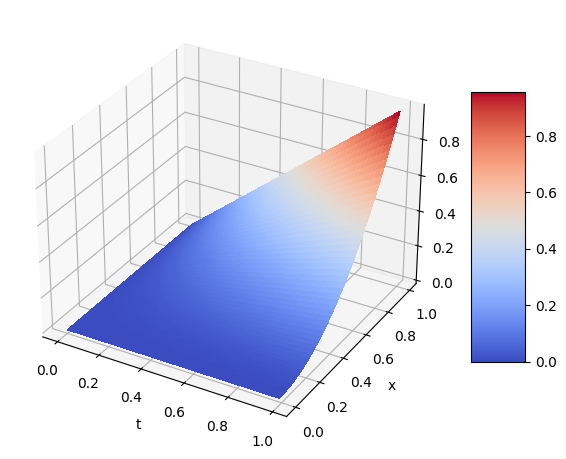

In [2]:
sol.plot2d(n = 100)

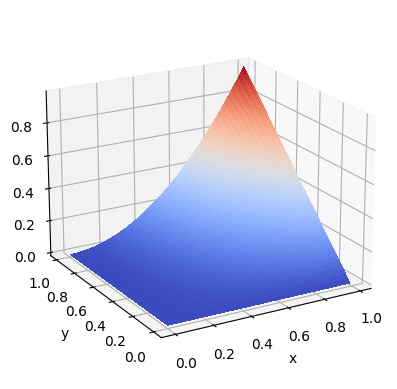

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm

n= 100
func = np.zeros((n,n))
ax1 = np.linspace(sol.area_lims[0,0], sol.area_lims[0,1], 100, endpoint=False)
ax2 = np.linspace(sol.area_lims[1,0], sol.area_lims[1,1], 100, endpoint=False)
grid = list(itertools.product(ax1, ax2))
for i in range(n):
        for j in range(n): 
                func[i, j] = sol.eval([ax1[i], ax2[j]], [0,0])
X, Y = np.meshgrid(ax1, ax2)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, func, cmap=cm.coolwarm,
        linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.view_init(20, -120)
# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

In [4]:
sol.cells_coefs[0,0]

array([[ 1.04137206e-01,  2.50000000e-01,  1.45862794e-01],
       [ 1.25000000e-01,  2.08274412e-01,  1.25000000e-01],
       [ 2.08627941e-02, -1.14114273e-16, -4.61148948e-17]])

In [5]:
sol.eval([0,0.01], [0,0], local=False)

1.1102230246251565e-16

In [2]:
dir([0.5, 1])

array([0, 1])

In [6]:
sol.basis.eval([0,0.2], [0,0])

array([[1.  , 0.  , 0.  ],
       [1.  , 0.2 , 0.04]])

In [7]:
sol.basis.eval([0,0.2], [0,0], ravel=True)

array([1.  , 0.2 , 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [8]:
a = sol.basis.eval([0.5,0.2], [0,0], ravel=False)

In [9]:
a

array([[1.  , 0.5 , 0.25],
       [1.  , 0.2 , 0.04]])

In [10]:
np.outer(a[0], a[1])

array([[1.  , 0.2 , 0.04],
       [0.5 , 0.1 , 0.02],
       [0.25, 0.05, 0.01]])

In [11]:
np.outer(a[0], a[1]).ravel(order='F').reshape(sol.cells_shape[-2:], order='F')

array([[1.  , 0.2 , 0.04],
       [0.5 , 0.1 , 0.02],
       [0.25, 0.05, 0.01]])

In [12]:
sol.basis.eval([1,1], [0,1], ravel=True)

array([0., 2., 4., 0., 2., 4., 0., 2., 4.])

In [13]:
sol.basis.eval([1,1], [0,1], ravel=False)

array([[1., 1., 1.],
       [0., 2., 4.]])

In [14]:
sol.cells_coefs[0,0]

array([[ 1.04137206e-01,  2.50000000e-01,  1.45862794e-01],
       [ 1.25000000e-01,  2.08274412e-01,  1.25000000e-01],
       [ 2.08627941e-02, -1.14114273e-16, -4.61148948e-17]])

In [3]:
sol.cells_coefs[0,0] = np.zeros((3,3))
sol.cells_coefs[0,0,0,1] = 1

In [4]:
sol.cells_coefs[0,0]

array([[0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [6]:
sol.eval(cell_num = [0,0], point=[1, 0.5], derivatives=[0,0], local=True)

1.0

In [7]:
sol.basis.eval([1,1], [0,1], ravel=False)[::-1]

array([[0., 2., 4.],
       [1., 1., 1.]])

In [8]:
sol.basis.eval([1,1], [0,1], ravel=False)

array([[1., 1., 1.],
       [0., 2., 4.]])

In [ ]:
a = copy.deepcopy(sol.cells_coefs[0,0])
for i in sol.basis.eval([1,1], [0,1], ravel=False)[::-1]
    a = a @ 
    